<h1>L.A. Intersection Vehicle Count Model</h1>

<p>The following is an attempt at predicting the number of vehicles passing through intersections within the city limits of Los Angeles.</p>
<p>The model accepts geolocation (lat and long), time of day (hour), and direction of travel (north, south, east or west).</p>
<p>There are two parts to this report. Part 1 is the final analysis. It's shown first because it illustrates the final model, which is the main purpose of this notebook. Part 2 fosuses on how the data was gathered, which is important and interesting, but is more of an exercise in software engineering than data analysis.
<p>&nbsp;&nbsp;&nbsp;- Part 1 includes tidying the data, EDA, cross validation, and the final model. The data needed some cleaning, like names of days of the week were inconsistent, etc. The data was stored in a format that required normalization as well. After generating a few visualizations, including animations, the variables with the strongest relaionships were identified. A KNN regression model was found to return the most accurate results, with an R-squared value of about 0.45</p>
<p>&nbsp;&nbsp;&nbsp;- Part 2 is a program that collected the majority of the data. The data source is a combination of open data and data gathered by parsing pdf files linked to webpages. The open data set, found <a href='http://geohub.lacity.org/datasets/traffic-data/data' target='_blank'>here</a>, provides the geolocation of the intersection and a url to a web page with links to detailed reports in pdf format (found in the "NLA_URL" column). The format of the pdf reports vary depending on the type of counting (manual vs automatic) and the date the report was created, so a specific style was parsed to simplify data extraction. While opportunity exists to gather additional data, the program was able to successfully process about 4,600 pdf files. The program uses various techniques, including performing web requests, saving to a MongoDB database, regular expressions, multi-threading, locking resources, file handling, JSON serialization, using a tabula package to convert pdf files to Pandas dataframes, and timing processes to gather performance metrics.</p>

<h2>Part 1 - Data Analysis</h2>

<h3>Import Packages and Data</h3>

<div>The data is imported from a JSON file. Originally, a MongoDB database was used to store the data, the commented code is left in for later usage.</div>

In [3]:
import pandas as pd
import numpy as np
#import pymongo
import json
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
import sklearn.model_selection as mod_sel
import sklearn.utils as utils
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as animation

#use json file for Jupyter Lab
#client = pymongo.MongoClient()
#db = client["TrafficData"]
#collection = db["IntersectionTrafficVolumes"]
#d = collection.find({})
#df = pd.DataFrame(d)
with open('InsertsectionTrafficVolumes.json') as f:
    j = f.read()
d = json.loads(j)
df = pd.DataFrame(d)
df.head()

,IntersectionId,SourceUrl,Latitude,Longitude,Intersection,Date,DayOfWeek,Direction,DotDistrict,Weather,Counter,PreparedBy,CounterMode,SerialNumber,TotalsByTimeOfDay,TotalNorthOrWest,TotalSouthOrEast
0,13431,http://navigatela.lacity.org/navigatela/report...,34.07819,-118.36478,LAUREL AV AT OAKWOOD AV,11/19/09,THURSDAY,N/S STREET,HW,CLEAR,ARMANDO,0,Classifier,RD97600 D,"[{'Time': '12 AM', 'NorthOrWestTotal': 4, 'Sou...",824,601
1,13428,http://navigatela.lacity.org/navigatela/report...,34.07821,-118.36144,FAIRFAX AV AT OAKWOOD AV,08/11/09,TUESDAY,N/S STREET,HW,CLEAR,ARMANDO,9,Classifier,RD97589 D,"[{'Time': '12 AM', 'NorthOrWestTotal': 314, 'S...",18783,17601
2,13460,http://navigatela.lacity.org/navigatela/report...,34.07528,-118.38164,GRACIE ALLEN DR AT GEORGE BURNS RD,02/03/10,WEDNESDAY,E/W STREET,HW,SUNNY,HUGO/LAVEDI,TY OF LOS ANGELES,Classifier,RD97558 D,"[{'Time': '12 AM', 'NorthOrWestTotal': 37, 'So...",3799,4726
3,13531,http://navigatela.lacity.org/navigatela/report...,34.06368,-118.44534,WESTWOOD BL N/O LE CONTE AV,03/10/10,WEDNESDAY,N/S STREET,WESTERN,SUNNNY,HUGO/LAVEDI,TY OF LOS ANGELES,Classifier,RD97546 D,"[{'Time': '12 AM', 'NorthOrWestTotal': 70, 'So...",10718,8496
4,13460,http://navigatela.lacity.org/navigatela/report...,34.07528,-118.38164,GEORGE BURNS RD AT GRACIE ALLEN DR,02/03/10,WEDNESDAY,N/S STREET,HW,SUNNY,HUGO/LAVEDI,TY OF LOS ANGELES,Classifier,RD97584 D,"[{'Time': '12 AM', 'NorthOrWestTotal': 53, 'So...",6839,7515


<div>Try a simple model with cross validation to get a feel for the shape of the data.</div>

In [14]:
df["Total"] = df["TotalNorthOrWest"] + df["TotalSouthOrEast"]
X = df[['Latitude', 'Longitude']]
y = df.Total
df = utils.shuffle(df)
X_train, X_test, y_train, y_test = mod_sel.train_test_split(X, y, test_size=0.3)
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)
knn.score(X_test, y_test)
vals = mod_sel.cross_val_score(knn, X, y, cv=mod_sel.KFold(n_splits=5, shuffle=True))
print(vals)
np.mean(vals)
#~0.21

[0.22454576 0.16341088 0.2078951  0.25347482 0.21251564]


0.21236843958015772

<h3>Tidying Data</h3>

<div>The TotalsByTimeOfDay column is an array of of objects containing an hour of the day, a count of vehicles in the North or West direction, and a count of vehicles in the South or East direction. So normalize the data so these values are in their own columns and data it tidy.</div>

In [5]:
df_dir = pd.json_normalize(d, 'TotalsByTimeOfDay', ['IntersectionId', 'SourceUrl', 'Latitude', 'Longitude', 'Intersection', 'Date', 'DayOfWeek', 'Direction', 'DotDistrict','Weather', 'Counter', 'PreparedBy', 'CounterMode', 'SerialNumber', 'TotalNorthOrWest', 'TotalSouthOrEast'])
df_dir.head()

,Time,NorthOrWestTotal,SouthOrEastTotal,IntersectionId,SourceUrl,Latitude,Longitude,Intersection,Date,DayOfWeek,Direction,DotDistrict,Weather,Counter,PreparedBy,CounterMode,SerialNumber,TotalNorthOrWest,TotalSouthOrEast
0,12 AM,4,5,13431,http://navigatela.lacity.org/navigatela/report...,34.0782,-118.365,LAUREL AV AT OAKWOOD AV,11/19/09,THURSDAY,N/S STREET,HW,CLEAR,ARMANDO,0,Classifier,RD97600 D,824,601
1,1 AM,7,4,13431,http://navigatela.lacity.org/navigatela/report...,34.0782,-118.365,LAUREL AV AT OAKWOOD AV,11/19/09,THURSDAY,N/S STREET,HW,CLEAR,ARMANDO,0,Classifier,RD97600 D,824,601
2,2 AM,3,1,13431,http://navigatela.lacity.org/navigatela/report...,34.0782,-118.365,LAUREL AV AT OAKWOOD AV,11/19/09,THURSDAY,N/S STREET,HW,CLEAR,ARMANDO,0,Classifier,RD97600 D,824,601
3,3 AM,1,0,13431,http://navigatela.lacity.org/navigatela/report...,34.0782,-118.365,LAUREL AV AT OAKWOOD AV,11/19/09,THURSDAY,N/S STREET,HW,CLEAR,ARMANDO,0,Classifier,RD97600 D,824,601
4,4 AM,0,2,13431,http://navigatela.lacity.org/navigatela/report...,34.0782,-118.365,LAUREL AV AT OAKWOOD AV,11/19/09,THURSDAY,N/S STREET,HW,CLEAR,ARMANDO,0,Classifier,RD97600 D,824,601


<h3>Cleaning Data</h3>

<div>The value of NorthOrWestTotal and SouthOrEastTotal depends on whether the street runs north and south or east and west. This was the format the data was found in, so we'll have to transform it slightly. We'll use the Direction column to determine which direction the street runs and set a new value TrafficDirection to either "North" or "East", later we'll copy the dataframe and set values for "South" and "West". The Direction values are inconsistent since they were likely input by hand, so we'll need to search for the different values. For example "N/S", "NB", and "NS STREET" are all various forms of "North". The same inconsistency issues exist for the DayOfWeek and Weather columns, so we'll clean them up too. The Counter and DotDistrict columns contain forward slashes and periods, which caused issues when converting to categorical data types, so replace with spaces and dashes, respectively.</div>

In [6]:
df_dir.Direction.unique()

array(['N/S STREET', 'E/W STREET', 'E/W STREET  east jog ',
       'E/W STREET  W/B ONE WAY STREET', 'E/W STREET    RT LANE ONLY',
       'E/W STREET  1-WAY ONLY', 'N/S STREET  1-WAY ONLY',
       'E/W STREET 1-WAY ONLY', 'E/W STREET   1-WAY ONLY',
       'E/W STREET    1-WAY ONLY', 'E/W STREET ', 'N/S STREET  south leg',
       'N/S STREET   north leg', 'N/S STREET   south leg',
       'N/S STREET   1-WAY ONLY', 'E/W STREET  at Driveway',
       'N/S STREET   1 WAY ONLY', 'N/S STREET ',
       'E/W STREET   1 WAY ONLY', 'E/W STREET  1 WAY ONLY',
       'N/S STREET  1- WAY ONLY', 'N/B STREET ONE WAY', 'EW STREET',
       'N/S STREET  1-WAYONLY', 'E/WSTREET', 'N/S STREET DRIVEWAY',
       'N/S Street', 'N/S STREET 1-WAY ONLY', 'NORTH/SOUTH STREET',
       'E/W STREET  1-WAY ONLY ', 'N/S STREET   NORTH LEG',
       'N/S STREET   SOUTH LEG', 'E/W STREET   NEAR CLARKSON',
       'N/S STREET   NEAR CLARKSON', 'E/W STREET  1-WAY',
       'N/S STREET  S/B DEPARTURE', 'N/S STREET  north leg',


In [10]:
df_dir["Total"] = df_dir["TotalNorthOrWest"] + df_dir["TotalSouthOrEast"]
df_dir['TrafficDirection'] = ''
df_dir['DirectionTotal'] = ''
df_dir.loc[df_dir.Direction.str.contains('N/S'), 'TrafficDirection'] = 'NORTH'
df_dir.loc[df_dir.Direction.str.contains('NORTH'), 'TrafficDirection'] = 'NORTH'
df_dir.loc[df_dir.Direction.str.contains('NB'), 'TrafficDirection'] = 'NORTH'
df_dir.loc[df_dir.Direction.str.contains('NS STREET'), 'TrafficDirection'] = 'NORTH'
df_dir.loc[df_dir.Direction.str.contains('N/B'), 'TrafficDirection'] = 'NORTH'
df_dir.loc[df_dir.Direction == 'N/S STREET', 'TrafficDirection'] = 'NORTH'
df_dir.loc[df_dir.TrafficDirection == 'NORTH', 'DirectionTotal'] = df_dir.loc[df_dir.TrafficDirection == 'NORTH', 'NorthOrWestTotal']
df_dir.loc[df_dir.Direction.str.contains('E/W'), 'TrafficDirection'] = 'EAST'
df_dir.loc[df_dir.Direction.str.contains('EAST'), 'TrafficDirection'] = 'EAST'
df_dir.loc[df_dir.Direction.str.contains('EB'), 'TrafficDirection'] = 'EAST'
df_dir.loc[df_dir.Direction.str.contains('EW STREET'), 'TrafficDirection'] = 'EAST'
df_dir.loc[df_dir.Direction.str.contains('E/B'), 'TrafficDirection'] = 'EAST'
df_dir.loc[df_dir.Direction.str.contains('E/W STREET'), 'TrafficDirection'] = 'EAST'
df_dir.loc[df_dir.TrafficDirection == 'EAST', 'DirectionTotal'] = df_dir.loc[df_dir.TrafficDirection == 'EAST', 'SouthOrEastTotal']
df_dir.DayOfWeek.unique()
df_dir.loc[df_dir.DayOfWeek.isin(['MON', 'MONDAY ']), 'DayOfWeek'] = 'MONDAY'
df_dir.loc[df_dir.DayOfWeek.isin(['TUES', 'TUEDAY', 'TUESADY']), 'DayOfWeek'] = 'TUESDAY'
df_dir.loc[df_dir.DayOfWeek == 'WED', 'DayOfWeek'] = 'WEDNESDAY'
df_dir.loc[df_dir.DayOfWeek.isin(['THUR', 'THURSADY', 'THUSDAY', 'THURDAY']), 'DayOfWeek'] = 'THURSDAY'
df_dir.loc[df_dir.DayOfWeek == 'FRI', 'DayOfWeek'] = 'FRIDAY'
df_dir.loc[df_dir.DayOfWeek == 'SAT', 'DayOfWeek'] = 'SATURDAY'
df_dir.loc[df_dir.DayOfWeek == 'SUN', 'DayOfWeek'] = 'SUNDAY'
df_dir.loc[df_dir.DayOfWeek == 'Day Of Week', ['DayOfWeek']] = 'WEDNESDAY'
df_dir.Weather.unique()
df_dir.loc[df_dir.Weather.isin(['SUNNNY', 'SUNNY', 'CLAR', 'TUESDAY', 'MONDAY', 'Weather', 'SUNDAY']), 'Weather'] = 'CLEAR'
df_dir.loc[df_dir.Weather.isin(['PT CLOUDY', 'COUDY']), 'Weather'] = 'CLOUDY'
df_dir.Counter.unique()
df_dir.Counter = df_dir.Counter.str.replace('.', ' ')
df_dir.Counter = df_dir.Counter.str.replace('/', '-')
df_dir.DotDistrict.unique()
df_dir.DotDistrict = df_dir.Counter.str.replace('.', ' ')
df_dir.DotDistrict = df_dir.Counter.str.replace('/', '-')
df_dir = df_dir.astype({'Time': 'category', 'IntersectionId': 'int64', 'Latitude': 'float', 'Longitude': 'float',
                'SourceUrl': 'string', 'Intersection': 'string', 'Date': 'string', 'Direction': 'category',
                'DotDistrict': 'category', 'PreparedBy': 'string', 'CounterMode': 'string', 'Counter': 'category',
                'SerialNumber': 'string', 'TotalNorthOrWest': 'int64', 'TotalSouthOrEast': 'int64',
                'DirectionTotal': 'int64', 'TrafficDirection': 'string'})

<div>Now that the data is clean and tidy, copy the dateframe and set values for South and West. So for all of the rows where TrafficDirection is North in the original frame, set to South and set DirectionTotal to the SouthOrEastTotal value. Repeat for West values. Then set the copy to None in order to free up memory.</div>

In [11]:
df_dir_copy = df_dir.copy()
df_dir_copy.loc[df_dir_copy.TrafficDirection == 'NORTH', 'TrafficDirection'] = 'SOUTH'
df_dir_copy.loc[df_dir_copy.TrafficDirection == 'SOUTH', 'DirectionTotal'] = df_dir_copy.loc[df_dir_copy.TrafficDirection == 'SOUTH', 'SouthOrEastTotal']
df_dir_copy.loc[df_dir_copy.TrafficDirection == 'EAST', 'TrafficDirection'] = 'WEST'
df_dir_copy.loc[df_dir_copy.TrafficDirection == 'WEST', 'DirectionTotal'] = df_dir_copy.loc[df_dir_copy.TrafficDirection == 'WEST', 'NorthOrWestTotal']
df_dir = df_dir.append(df_dir_copy)
df_dir.reset_index(drop = True, inplace = True)
df_dir = df_dir.astype({'TrafficDirection': 'category', 'DayOfWeek': 'category', 'Weather': 'category'})
df_dir_copy = None

<h3>Visualize Data</h3>

<div>This routine plots the intersection with a color map in order to visualize the traffic volumes. Folium was used for it's simple installation. The final result is shown below. Patterns are noticable, indicating geolocation is a relevant variable.</div>

In [ ]:
import folium

def set_color_range():
    start = 0.65
    stop = 0.98
    global number_of_lines
    number_of_lines = 1000
    cm_subsection = np.linspace(start, stop, number_of_lines)
    global colors
    colors = [plt.cm.jet(x) for x in cm_subsection]

def get_color(value):
    color_idx = int(round(((value - count_min) / (count_max - count_min)) * (number_of_lines - 1)))
    color = colors[color_idx]
    return color

def dec_to_rgb(rgb_part):
    return int(round(rgb_part * 255))

def get_circle_color(value):
    color = get_color(value)
    rgb_color = (dec_to_rgb(color[0]), dec_to_rgb(color[1]), dec_to_rgb(color[2]))
    hex_color = '#%02x%02x%02x' % (rgb_color[0], rgb_color[1], rgb_color[2])
    return hex_color

count_max = df['Total'].max()
count_min = df['Total'].min()

set_color_range()
m = folium.Map(
   location=[33.998251,-118.3848547],
   tiles='Stamen Toner'
)
for index, row in df.iterrows():
     folium.Circle(
        location = [row['Latitude'], row['Longitue']],
        radius = 100,
        color = get_circle_color(row['Total']),
        fill = False).add_to(m2)
#m.save('~/traffic_map.html')

In [2]:
%%HTML
<iframe src='traffic_map.html' width='750' height='650'></iframe>

<div>Show change (in percentage) by time of day</div>

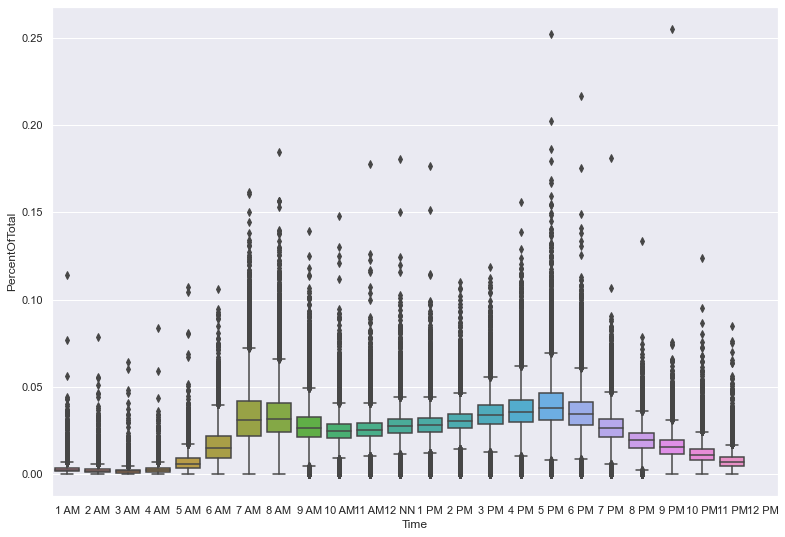

In [14]:
df_dir["PercentOfTotal"] = df_dir["DirectionTotal"] / df_dir["Total"]
times = ['1 AM','2 AM','3 AM','4 AM','5 AM','6 AM','7 AM','8 AM','9 AM','10 AM','11 AM','12 NN','1 PM','2 PM','3 PM','4 PM','5 PM','6 PM','7 PM','8 PM','9 PM','10 PM','11 PM','12 PM']
sns.set(rc={'figure.figsize':(13,9)})
sns.boxplot(x = 'Time', y = 'PercentOfTotal', order = times, data = df_dir)


<div>This is the code that was used to generate the Traffic West Animation.mp4 animation. The animation shows traffic volumes in the western direction changing with time. It may not render below but is included in the repository. The last few commented lines are left for later usage.</div>

In [22]:
#fig = plt.figure()
#ax = plt.axes()
points = ax.scatter(df_dir.loc[(df_dir.TrafficDirection == "WEST") & (df_dir.Time == "1 AM")]["Longitude"],
                    df_dir.loc[(df_dir.TrafficDirection == "WEST") & (df_dir.Time == "1 AM")]["Latitude"],
                    c = df_dir.loc[(df_dir.TrafficDirection == "WEST") & (df_dir.Time == "1 AM")]["DirectionTotal"])
def animate_west(i):
    time = times[i]
    points.set_offsets(df_dir.loc[(df_dir.TrafficDirection == "WEST") & (df_dir.Time == "1 AM"), ["Longitude", "Latitude"]])
    points.set_array(df_dir.loc[(df_dir.TrafficDirection == "WEST") & (df_dir.Time == time)]["DirectionTotal"])
    return points,
#anim = animation.FuncAnimation(fig, animate_west, frames=23, interval=1000, blit=True)
#not saving here, just displaying final result.
#anim.save('Traffic West Animation.mp4', fps=1, extra_args=['-vcodec', 'libx264'])

In [3]:
%%HTML
<video controls src="Traffic West Animation.mp4"/>

<div>The Traffic East Animation.mp4 animation was created the same way, except it shows traffic flow in the eastern direction changing by time of day. There are differences in the east and west animations, indicating direction and time are variables that should be included in the model.</div>

In [4]:
%%HTML
<video controls src="../Traffic East Animation.mp4" />

<h3>Modeling</h3>

<div>KNN regression using continuous variables lat, long, and categorical variables time of day and direction. We'll convert categorical variables to dummy variables using the get_dummies method.</div>

In [5]:
df_dir_time = df_dir[['Time','Latitude', 'Longitude', 'DirectionTotal', 'TrafficDirection']]
df_dir_time = utils.shuffle(df_dir_time)
df_dir_time_model = pd.get_dummies(df_dir_time, prefix = '', prefix_sep = '')
X = df_dir_time_model.drop('DirectionTotal', axis = 1)
y = df_dir_time_model.DirectionTotal
X_train, X_test, y_train, y_test = mod_sel.train_test_split(X, y, test_size=0.3)
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)
knn.score(X_test, y_test)
#0.44502615723744554

0.4427261061767843

<div>By adding time and direction to our model, the r-squared has increased by over 100%.</div>

<h3>Part 2 - Pdf Scraper</h3>

<div>Here is the program that was used to gather the data for the analysis in Part 1. It loops though an open dataset using Python's ThreadPoolExecutor to run asyncronously. While it isn't a true multi-threaded progam, it does perform many tasks that benefit from asycronous operation, such as http requests and writing and reading files. Tests showed an average of 60% reduction in run time due to running asyncronously.</div>
<div>One example of a page it uses can be found <a href='http://navigatela.lacity.org/navigatela/reports/dot_traffic_data_report.cfm?trafficid=240' target='_blank'>here</a>. If you click a few of the links, you'll notice the reports come in several different formats. Files in a format like <a href='https://navigatela.lacity.org/dot/traffic_data/automatic_counts/ALVARADO.WILSHIRE.180529-AUTO.pdf' target='_blank'>this</a> seemed both abundant and from a time period the could still be considered relevant since most were created within the last ten years. Also, urls from the "Manual Counts" section were not targeted, only automatic counts were used because the data and format was much more consistent. </div>
<div>The PyPDF4 module is used to read the pdf file's text to determine whether it's in a usable format. If a report in the correct format was found, an IntersectionTrafficVolume object is instantiated and hydrated by searching the pdf text for relavant values. Then a Tabula module converts the pdf file to a Pandas dataframe and gather the traffic volumes by time and direction. The object is then converted to a dictionary and stored in a MongoDB database. A global variable that tracks how many records were created, and timing how long it took to complete were used to determine performance of the program. The count variable required locking in order to be accurate. Of the approximate 10K rows, about 4600 pdf files were found and parsed.</div>

In [ ]:
import re
import pandas as pd
import pymongo
import PyPDF4
import tabula
import requests
import time
import concurrent.futures
import threading

class IntersectionTrafficVolume:
    def __int__(self):
        self.IntersectionId = None
        self.Intersection = None
        self.SourceUrl = None
        self.Location = None
        self.Latitude = None
        self.Longitude = None
        self.Date = None
        self.DayOfWeek = None
        self.Direction = None
        self.DotDistrict = None
        self.Weather = None
        self.Counter = None
        self.PreparedBy = None
        self.CounterMode = None
        self.SerialNumber = None
        self.Total = None
        self.TotalNorthOrWest = None
        self.TotalSouthOrEast = None
        self.TotalsByTimeOfDay = None

class TrafficVolumeByTime:
    def __int__(self):
        self.Time = None
        self.NorthOrWestTotal = None
        self.SouthOrEastTotal = None

class pdfScraper:
    def __int__(self):
        self.RowData = None
        self.RowNum = None
        self.UrlHtml = None
        self.PdfUrls = None
        self.PdfTexts = None
        self.Report = None

    def scrape(self):
        response = requests.get(self.RowData.NLA_URL)
        if (hasattr(response, 'text') and response.text.find('Automatic Count (PDF)') > 0):
            self.UrlHtml = response.text
            self.PdfUrls = self.get_pdf_urls()
            if (len(self.PdfUrls) > 0):
                self.get_pdfs()
                if (len(self.PdfTexts) > 0):
                    self.processPdfs()

    def get_pdf_urls(self):
        # try to get only automatic reports
        start = self.UrlHtml.index('Automatic Count (PDF)')
        stop = self.UrlHtml.index('Manual Count (PDF)') if start < self.UrlHtml.index('Manual Count (PDF)') else len(self.UrlHtml)
        searchText = ''
        if (start < stop):
            searchText = self.UrlHtml[start:stop]
        else:
            searchText = self.UrlHtml[start:]
        urls = re.findall(r'href=[\'"]?([^\'">]+)', searchText)
        return urls

    def get_pdfs(self):
        texts = []
        docIdx = 0
        for pdfUrl in self.PdfUrls:
            try:
                pdfResp = requests.get(pdfUrl, stream=True)
                text = self.get_pdf_text(pdfResp.content, docIdx)
                if (text.find('NORTHBOUND or WESTBOUND') >= 0):
                    texts.append([text, docIdx])
            except Exception as e:
                print("Error getting pdf stream at " + pdfUrl)
                print(e)
            finally:
                docIdx = docIdx + 1
        self.PdfTexts = texts

    def get_pdf_text(self, stream, ct):
        pageText = "";
        with open("traffic_" + str(self.RowData.IntersectionID) + "_" + str(ct) + ".pdf", 'wb') as f:
            f.write(stream)
            pdfFileObj = open("traffic_" + str(self.RowData.IntersectionID) + "_" + str(ct) + ".pdf", 'rb')
            reader = PyPDF4.PdfFileReader(pdfFileObj)
            page = reader.getPage(0)
            pageText = page.extractText()
        return pageText

    def processPdfs(self):
        for pdfText in self.PdfTexts:
            docText = pdfText[0]
            docIndex = pdfText[1]
            self.Report = IntersectionTrafficVolume()
            self.Report.IntersectionId = int(self.RowData.IntersectionID)
            self.Report.SourceUrl = self.RowData.NLA_URL
            self.Report.Latitude = self.RowData.lat
            self.Report.Longitude = self.RowData.lon
            self.Report.Intersection = self.get_value_from_pdf_text(docText, "Location\n", "\n")
            self.Report.Date = self.get_value_from_pdf_text(docText, "Date\n", "\n")
            self.Report.DayOfWeek = self.get_value_from_pdf_text(docText, "Day of Week\n", "\n")
            self.Report.Direction = self.get_value_from_pdf_text(docText, "Direction\n", "\n")
            self.Report.DotDistrict = self.get_value_from_pdf_text(docText, "DOT District\n", "\n")
            self.Report.Weather = self.get_value_from_pdf_text(docText, "Weather\n", "\n")
            self.Report.Counter = self.get_value_from_pdf_text(docText, "Counter\n", "\n")
            self.Report.PreparedBy = self.get_value_from_pdf_text(docText, "By\n", "\n")
            self.Report.CounterMode = self.get_value_from_pdf_text(docText, "Counter Mode\n", "\n")
            self.Report.SerialNumber = self.get_value_from_pdf_text(docText, "Serial Number\n", "\n")
            try:
                print("Try getting time records for " + str(self.RowNum))
                volumeByTimeReports = self.build_volume_by_time_reports(docIndex)
                self.Report.TotalsByTimeOfDay = volumeByTimeReports[0]
                self.Report.TotalNorthOrWest = volumeByTimeReports[1]
                self.Report.TotalSouthOrEast = volumeByTimeReports[2]
            except Exception as e:
                print("Error occurred getting time records for " + str(self.RowNum) + ". Error: ")
                print(e)
            self.save_report()
            with lock:
                global reportCount
                reportCount += 1        

    def get_value_from_pdf_text(self, strng, label, stopVal):
        start = strng.find(label) + len(label)
        if (start >= 0):
            stop = strng[start:].find(stopVal)
            return strng[start:start + stop]
        else:
            return None

    def build_volume_by_time_reports(self, docIndex):
        reports = []
        nwTotal = 0
        seTotal = 0
        pdf_df = tabula.read_pdf("traffic_" + str(self.RowData.IntersectionID) + "_" + str(docIndex) + ".pdf", pages=1)
        for index, timeRow in pdf_df[0].iloc[2:].iterrows():
            volume = TrafficVolumeByTime()
            volume.Time = timeRow.iloc[0]
            nw = timeRow.iloc[2].split(' ')
            if (len(nw) > 0):
                if (nw[-1].isdigit()):
                    nwRowTot = int(nw[-1])
                    volume.NorthOrWestTotal = nwRowTot
                    nwTotal += nwRowTot
            se = timeRow.iloc[4].split(' ')
            if (len(se) > 0):
                if (se[-1].isdigit()):
                    seRowTot = int(se[-1])
                    volume.SouthOrEastTotal = seRowTot
                    seTotal += seRowTot
            reports.append(volume)
        return [reports, nwTotal, seTotal]

    def save_report(self):
        dict = vars(self.Report)
        volDict = []
        for vol in self.Report.TotalsByTimeOfDay:
            volDict.append(vars(vol))
        dict["TotalsByTimeOfDay"] = volDict
        collection.insert_one(dict)

def process_intersection_row(row):
    scraper = pdfScraper()
    scraper.RowNum = row[0]
    scraper.RowData = row[1]
    print("Row num " + str(scraper.RowNum))
    scraper.scrape()

if __name__ == "__main__":
    client = pymongo.MongoClient()
    db = client["TrafficData"]
    collection = db["IntersectionTrafficVolumes"]
    df = pd.read_csv("Traffic_Data_Geoloc_tidy.csv")
    start = time.time()
    lock = threading.Lock()
    reportCount = 0
    with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
        executor.map(process_intersection_row, df.iterrows())
    end = time.time()
    print(end - start)
    print("Reports count: " + (str(reportCount)))



